In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2 as cv
import os
from sklearn.preprocessing import OneHotEncoder

from sklearn.utils import shuffle
import pickle
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [2]:
def charge_dataset(ruta):
    File = open(ruta, 'rb')
    data_x_tmp = pickle.load(File)
    data_y = pickle.load(File)
    File.close()
    del(File)
    return data_x_tmp, data_y

def convpool(X, W, b):
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)

In [3]:
ruta = 'dataset/test_data.pckl'
X_test, Y_test = charge_dataset(ruta)

In [4]:
print('formato para X_test: {}, formato para Y_test: {}'.format(X_test.shape, Y_test.shape))

formato para X_test: (2403, 12288), formato para Y_test: (2403, 2)


In [5]:
n_char = np.shape(X_test)[1]         # Número de cararcteristicas
n_class = np.shape(Y_test)[1]
hidden_layer_size = 300
samples = np.shape(X_test)[0]
colmns = np.shape(X_test)[1]
print(colmns)

12288


In [6]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [samples, 64, 64, 3])
Y = tf.placeholder(tf.float32, [samples, n_class])

In [7]:
W1 = tf.get_variable("W1", [8, 8, 3, 32])
b1 = tf.get_variable("b1", 32)
W2 = tf.get_variable("W2",[8, 8, 32, 64])
b2 = tf.get_variable("b2", 64)
W3 = tf.get_variable("W3",[16*16*64, hidden_layer_size])
b3 = tf.get_variable("b3",[hidden_layer_size])
W4 = tf.get_variable("W4",[hidden_layer_size, n_class])
b4 = tf.get_variable("b4",n_class)

W1119 19:00:09.634253 14772 deprecation.py:506] From C:\Users\joseo\Anaconda3\envs\automatas\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Z = tf.matmul(Z3, W4) + b4
y_ = tf.nn.tanh(Z)

In [9]:
predice = tf.argmax(y_, 1)
prediccion = tf.equal(tf.argmax(y_, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(prediccion, tf.float32))

In [10]:
conf_matrix = tf.confusion_matrix(tf.argmax(y_, 1), tf.argmax(Y, 1))
print(conf_matrix.shape)

(?, ?)


In [11]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, os.getcwd()+"/modeloCNN.ckpt")
    X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)
    test_accuracy = sess.run([accuracy], feed_dict={X: X_test, Y: Y_test})
    test_accuracy_percent = test_accuracy[0] * 100.
    print('Test accuracy: '+'{0:.2f}'.format(test_accuracy_percent)+'%')
    predice = sess.run([predice], feed_dict={X: X_test, Y: Y_test}) 
    conf_mat = sess.run([conf_matrix], feed_dict={X: X_test, Y: Y_test})
    print(conf_mat[0])

W1119 19:00:11.477184 14772 deprecation.py:323] From C:\Users\joseo\Anaconda3\envs\automatas\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Test accuracy: 89.51%
[[1079  138]
 [ 114 1072]]


Text(0.5, 257.44, 'Mujeres - Hombres')

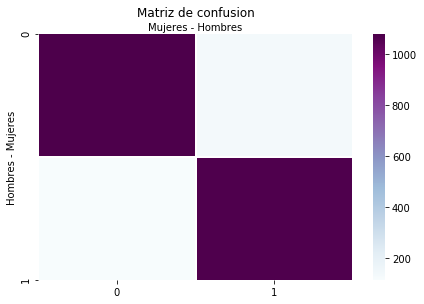

In [12]:
class_labels = ['Mujeres','Hombres']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

sns.heatmap(pd.DataFrame(conf_mat[0]), cmap="BuPu", annot=False,
            fmt='d', linewidths=1 ,annot_kws={"size": 20})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Matriz de confusion')
plt.ylabel('Hombres - Mujeres')
plt.xlabel('Mujeres - Hombres')

In [13]:
Vp = conf_mat[0][0][0] 
Fn = conf_mat[0][0][1]
Fp = conf_mat[0][1][0]
Vn = conf_mat[0][1][1]

In [14]:
positive = Vp + Fn
negative = Fp + Vn
print("Positivos: {}, Negativos: {}.".format(positive, negative))

Positivos: 1217, Negativos: 1186.


In [15]:
pred_positive = Vp + Fp
pred_negative = Vn + Fn
print("Predichos Positivos: {}, Predichos Negativos: {}.".format(pred_positive, pred_negative))

Predichos Positivos: 1193, Predichos Negativos: 1210.


In [16]:
mtx_total = positive + negative
mtx_accuracy = ((Vp + Vn)/mtx_total) * 100
mtx_error_rate = ((Fp + Fn)/mtx_total) * 100
mtx_sensibility = (Vp/pred_positive) * 100
mtx_specificity = (Vn/pred_negative) * 100
print("Accuracy: {:.4f}%, Error Rate: {:.4f}%, Sensibility: {:.4f}%, Specificity: {:.4f}%."
      .format(mtx_accuracy, mtx_error_rate, mtx_sensibility, mtx_specificity))

Accuracy: 89.5131%, Error Rate: 10.4869%, Sensibility: 90.4443%, Specificity: 88.5950%.


In [17]:
mtx_precision = (Vp/positive) * 100 
mtx_vpn = (Vn/negative) * 100
print("Precision: {:.2f}%, Prediction: {:.2f}%".format(mtx_precision, mtx_vpn))

Precision: 88.66%, Prediction: 90.39%


Esta etiquetado como un: Mujer
Lo predice como un como un: Mujer


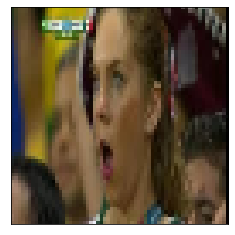

In [18]:
index = 333
img = X_test[index][0:samples];
img_reshape = img.reshape([64,64,3])
#m2 = im2.T;
plt.imshow(img_reshape)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
if(np.argmax(Y_test[index]) == 1):
    etiqueta = 'Hombre'
else: 
    etiqueta = 'Mujer'

if(predice[0][index] == 1):
    res = 'Hombre'
else: 
    res = 'Mujer'
    
print('Esta etiquetado como un: {}'.format(etiqueta))
print('Lo predice como un como un: {}'.format(res))

# cargo una imagen

In [ ]:
def _print_dim(dimx):
    print("Dimensión de X {}".format(dimx.shape))
    
    
def get_images(test_ruta, Xt):
    img = cv.imread(test_ruta,3)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ima = cv.resize(img,(64,64))
    Xt.append(ima)
    return Xt

In [ ]:
test_ruta = 'images/test/test1.jpg'
Xt = get_images(test_ruta, Xt=list())
img = np.array(Xt)

In [ ]:
_print_dim(img)

In [ ]:
img_reshape = img.reshape([64,64,3])
#m2 = im2.T;
plt.imshow(img_reshape)

In [ ]:
tf.reset_default_graph()
X_ph = tf.placeholder(tf.float32, [1, 64, 64, 3])
Y_ph = tf.placeholder(tf.float32, [1, n_class])

ss = tf.train.Saver()
with tf.Session() as sess:
    ss.restore(sess, os.getcwd()+"/modeloCNN.ckpt")
    img = img.reshape(img.shape[0], 64, 64, 3)
    predice = sess.run([predice], feed_dict={X_ph: img}) 